In [131]:
# !/home/arash/anaconda3/bin/pip install progressbar2

In [132]:
import torch
import torch.nn as nn
import torch.utils
from torchvision import datasets, transforms
import torchvision.utils
import numpy as np
import matplotlib.pyplot as plt

In [133]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import itertools
import time

# from progressbar import progressbar as pb

In [134]:
# FOR DEBUG PURPOSES
class Timer:
    def __init__(self, msg):
        self.msg = msg
        
    def __enter__(self):
        torch.cuda.synchronize()
        self.start = time.process_time()
        return self

    def __exit__(self, *args):
        torch.cuda.synchronize()
        self.end = time.process_time()
        self.interval = self.end - self.start
        
        print('{}: {:.5f}'.format(self.msg, self.interval))

In [135]:
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [136]:
n_gaussian = 8  # size of latent gaussian variable
block_size = 2  # size of coordinate search blocks
n_rounds = 4  # number of coordinate search rounds 

# n_b = 0  # size of the latent binary variable
# n_o = 0  # size of the latent one-hot variable

batch_size = 64  # samples of data distribution at each iteration
latent_batch_size = np.power(32, block_size)

n_epochs = 100

In [137]:
img_size = 32  # desired resized image size
nc = 1  # number of image channels
# workers = 2  # number of workers for dataloader

In [138]:
use_cuda = torch.cuda.is_available()
gpu_ids = '0,1'
gpu_ids = [int(s) for s in gpu_ids.split(',')]
device = torch.device("cuda:{}".format(gpu_ids[0]) if use_cuda else "cpu")

# if len(gpu_ids) > 0:
#     torch.cuda.set_device(gpu_ids[0])

torch.manual_seed(42)
np.random.seed(42)

# Should the default pytorch URL may fail, edit the source code of EMNIST function and update the URL
# E.g: vim ~/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py
# Correct URL as of Jan 2020: https://cloudstor.aarnet.edu.au/plus/s/ZNmuFiuQTqZlu9W/download



dataset_mean, dataset_std = 0.1751, 0.3332
train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', split='balanced', train=True, download=True,
                    transform=transforms.Compose([
#                         transforms.Resize(img_size),
                        transforms.ToTensor(),
                        transforms.Normalize((dataset_mean,), (dataset_std,))
                    ])),
    batch_size=batch_size, shuffle=True, drop_last=True)


# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=batch_size, shuffle=True, drop_last=True)

In [139]:
class BlockCoordinateSearch():
    def __init__(self, batch_size, latent_batch_size, n_gaussian, n_rounds, block_size, criterion_no_reduction, device, netG):
        """
        Block coordinate grid search optimizer over the distribution of points 
        in the latent space.
        
        Args:
            criterion_no_reduction: loss function to compare, and MUST NOT have reduction.
        """
        
#         self.m = torch.distributions.multivariate_normal.MultivariateNormal(
#             torch.zeros(block_size), 
#             torch.eye(block_size))
        
        self.batch_size = batch_size
        self.latent_batch_size = latent_batch_size
        self.n_gaussian = n_gaussian
        self.block_size = block_size
        
        self.n_rounds = n_rounds
        
#         self.netG = netG
        self.criterion_no_reduction = criterion_no_reduction
        
#         if device.type == 'cuda':
#             torch.cuda.set_device(device)
#             self.torch = torch.cuda
#         else:
#             self.torch = torch
        self.device = device
        self.netG = netG
        
    def _sample_block(self, old_z, block_idx):
        """
        Takes the best codes and perturbs
        
        Args:
            old_z: batch_size x n_gaussian
        Returns:
            new_z: batch_size x latent_batch_size x n_gaussian
        """
        
#         gaussian_samples = torch.randn(self.batch_size, self.latent_batch_size, self.block_size, device=device)
        
        new_z = old_z.unsqueeze(1).repeat(1, self.latent_batch_size, 1)
        new_z[:, :, block_idx * self.block_size:(block_idx + 1) * self.block_size].normal_()
        
        return new_z
        
#     def _row_wise_repeat(mat, n_rep):
#         """
#         pytorch equivalent of numpy.repeat
#         """
#         n_rows = mat.shape[0]
#         return mat[np.arange(n_rows).repeat(n_rep), :]  # WARNING: np.repeat has a different functionality from torch.repeat

    def optimize(self, real):
        """
        Find the loss between the optimal fake data and the real data.
        
        Args:
            real: batch_size x dim_1 x ... x dim_k
            
        Returns:
            best_z: batch_size x n_gaussian
        """
        for round_idx, block_idx in itertools.product(range(self.n_rounds), range(n_gaussian // block_size)):
            if round_idx == block_idx == 0:
                best_z = torch.zeros(self.batch_size, self.n_gaussian, device=self.device)
#             # batch_size x latent_batch_size x n_gaussian
            new_z = self._sample_block(best_z, block_idx)

            if True:  # if netG is a deconv network
                # (batch_size * latent_batch_size) x n_gaussian x 1 x 1
                new_z_r = new_z.reshape(self.batch_size * self.latent_batch_size, self.n_gaussian, 1, 1)
            else:
                new_z_r = new_z.reshape(self.batch_size * self.latent_batch_size, self.n_gaussian)

            # (batch_size * latent_batch_size) x dim_1 x ... x dim_k
            torch.cuda.synchronize()
            with torch.no_grad():  # no need to store the gradients while searching
                fake_all = self.netG(new_z_r)

            # batch_size x latent_batch_size x dim_1 x ... x dim_k

            all_shape = [self.batch_size, self.latent_batch_size, *real.shape[1:]]

            # batch_size x latent_batch_size x dim_1 x ... x dim_k
            fake_all = fake_all.reshape(all_shape)
            real_all = real.unsqueeze(1).expand(all_shape)

            # batch_size x latent_batch_size x dim_1 x ... x dim_k
            loss = self.criterion_no_reduction(real_all, fake_all)

            # batch_size x latent_batch_size x -1
            loss = loss.reshape([*all_shape[:2], -1])

            # batch_size x latent_batch_size
            loss = loss.mean(dim=2)

            # batch_size
            _, argmin = loss.min(dim=1)

            # new_z: batch_size x latent_batch_size x n_gaussian
            # best_idx: batch_size x 1 x n_gaussian
            best_idx = argmin[:, None, None].repeat(1, 1, self.n_gaussian)

            # batch_size x 1 x n_gaussian
            best_z = torch.gather(new_z, 1, best_idx)

            # batch_size x n_gaussian
            best_z = best_z.squeeze()
                                            
#         x_train = latent_code_dist.sample(latent_batch_size).to(device)
#         y_train = real.repeat(latent_batch_size, 1)
        
#         y_pred = row_wise_repeat(netG(x_train), batch_size)

#         loss_all_modes = loss_fn(y_pred, y_train)
        

#         # Zero the gradients before running the backward pass.
#         optimizer.zero_grad()
        
#         selective_loss = loss_all_modes.mean(dim=1).reshape(latent_batch_size, batch_size).min(dim=0)[0].sum()
  

        return best_z

In [140]:
# # D_in is input dimension;
# # H is hidden dimension;
# # D_out is output dimension.

# D_in, H, D_out = n_gaussian, 100, 28 * 28

# netG = torch.nn.Sequential(
#     torch.nn.Linear(D_in, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, D_out),
# ).to(device)

In [141]:
ngf = 64

In [142]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, gpu_ids):
        super(Generator, self).__init__()
        self.gpu_ids = gpu_ids
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( n_gaussian, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
#             nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        y = self.main(input)
        for dim in (2,3):
            y = y.narrow(dim, start=2, length=28)
        return y
    
# Create the generator
netG = Generator(gpu_ids).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (len(gpu_ids) > 1):
    netG = nn.DataParallel(netG, gpu_ids)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(8, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): Tanh()
    )
  )
)

In [143]:
optimizer = optim.Adam(netG.parameters(), betas=(0.5, 0.999))

criterion = torch.nn.L1Loss()
criterion_no_reduction = torch.nn.L1Loss(reduction='none')

bcs = BlockCoordinateSearch(batch_size, latent_batch_size, n_gaussian, n_rounds, block_size, criterion_no_reduction, device, netG)

loss_log = []

In [144]:
fixed_noise = torch.randn(64, n_gaussian, 1, 1, device=device)
img_list = []

Iteration 0


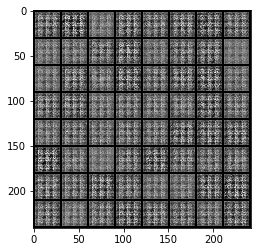

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50


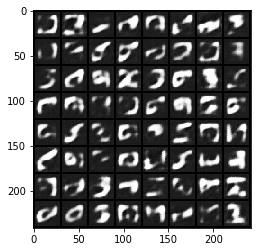

Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteration 78
Iteration 79
Iteration 80
Iteration 81
Iteration 82
Iteration 83
Iteration 84
Iteration 85
Iteration 86
Iteration 87
Iteration 88
Iteration 89
Iteration 90
Iteration 91
Iteration 92
Iteration 93
Iteration 94
Iteration 95
Iteration 96
Iteration 97
Iteration 98
Iteration 99
Iteration 100


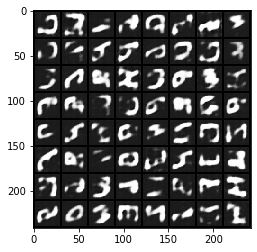

Iteration 101
Iteration 102
Iteration 103
Iteration 104
Iteration 105
Iteration 106
Iteration 107
Iteration 108
Iteration 109
Iteration 110
Iteration 111
Iteration 112
Iteration 113
Iteration 114
Iteration 115
Iteration 116
Iteration 117
Iteration 118
Iteration 119
Iteration 120
Iteration 121
Iteration 122
Iteration 123
Iteration 124
Iteration 125
Iteration 126
Iteration 127
Iteration 128
Iteration 129
Iteration 130
Iteration 131
Iteration 132
Iteration 133
Iteration 134
Iteration 135
Iteration 136
Iteration 137
Iteration 138
Iteration 139
Iteration 140
Iteration 141
Iteration 142
Iteration 143
Iteration 144
Iteration 145
Iteration 146
Iteration 147
Iteration 148
Iteration 149
Iteration 150


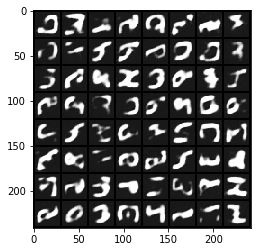

Iteration 151
Iteration 152
Iteration 153
Iteration 154
Iteration 155
Iteration 156
Iteration 157
Iteration 158
Iteration 159
Iteration 160
Iteration 161
Iteration 162
Iteration 163
Iteration 164
Iteration 165
Iteration 166
Iteration 167
Iteration 168
Iteration 169
Iteration 170
Iteration 171
Iteration 172
Iteration 173
Iteration 174
Iteration 175
Iteration 176
Iteration 177
Iteration 178
Iteration 179
Iteration 180
Iteration 181
Iteration 182
Iteration 183
Iteration 184
Iteration 185
Iteration 186
Iteration 187
Iteration 188
Iteration 189
Iteration 190
Iteration 191
Iteration 192
Iteration 193
Iteration 194
Iteration 195
Iteration 196
Iteration 197
Iteration 198
Iteration 199
Iteration 200


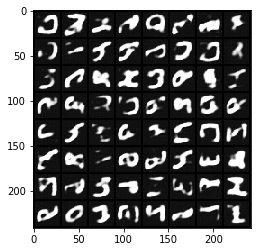

Iteration 201
Iteration 202
Iteration 203
Iteration 204
Iteration 205
Iteration 206
Iteration 207
Iteration 208
Iteration 209
Iteration 210
Iteration 211
Iteration 212
Iteration 213
Iteration 214
Iteration 215
Iteration 216
Iteration 217
Iteration 218
Iteration 219
Iteration 220
Iteration 221
Iteration 222
Iteration 223
Iteration 224
Iteration 225
Iteration 226
Iteration 227
Iteration 228
Iteration 229
Iteration 230
Iteration 231
Iteration 232
Iteration 233
Iteration 234
Iteration 235
Iteration 236
Iteration 237
Iteration 238
Iteration 239
Iteration 240
Iteration 241
Iteration 242
Iteration 243
Iteration 244
Iteration 245
Iteration 246
Iteration 247
Iteration 248
Iteration 249
Iteration 250


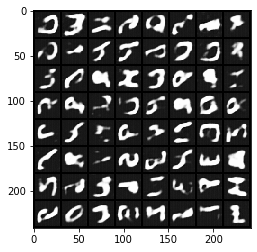

Iteration 251
Iteration 252
Iteration 253
Iteration 254
Iteration 255
Iteration 256
Iteration 257
Iteration 258
Iteration 259
Iteration 260
Iteration 261
Iteration 262
Iteration 263
Iteration 264
Iteration 265
Iteration 266
Iteration 267
Iteration 268
Iteration 269
Iteration 270
Iteration 271
Iteration 272
Iteration 273
Iteration 274
Iteration 275
Iteration 276
Iteration 277
Iteration 278
Iteration 279
Iteration 280
Iteration 281
Iteration 282
Iteration 283
Iteration 284
Iteration 285
Iteration 286
Iteration 287
Iteration 288
Iteration 289
Iteration 290
Iteration 291
Iteration 292
Iteration 293
Iteration 294
Iteration 295
Iteration 296
Iteration 297
Iteration 298
Iteration 299
Iteration 300


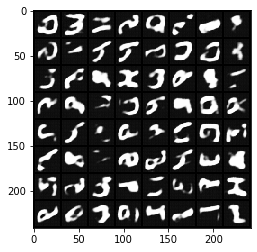

Iteration 301
Iteration 302
Iteration 303
Iteration 304
Iteration 305
Iteration 306
Iteration 307
Iteration 308
Iteration 309
Iteration 310
Iteration 311
Iteration 312
Iteration 313
Iteration 314
Iteration 315
Iteration 316
Iteration 317
Iteration 318
Iteration 319
Iteration 320
Iteration 321
Iteration 322
Iteration 323
Iteration 324
Iteration 325
Iteration 326
Iteration 327
Iteration 328
Iteration 329
Iteration 330
Iteration 331
Iteration 332
Iteration 333
Iteration 334
Iteration 335
Iteration 336
Iteration 337
Iteration 338
Iteration 339
Iteration 340
Iteration 341
Iteration 342
Iteration 343
Iteration 344
Iteration 345
Iteration 346
Iteration 347
Iteration 348
Iteration 349
Iteration 350


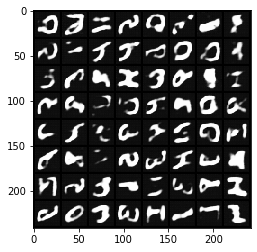

Iteration 351
Iteration 352
Iteration 353
Iteration 354
Iteration 355
Iteration 356
Iteration 357
Iteration 358
Iteration 359
Iteration 360
Iteration 361
Iteration 362
Iteration 363
Iteration 364
Iteration 365
Iteration 366
Iteration 367
Iteration 368
Iteration 369
Iteration 370
Iteration 371
Iteration 372
Iteration 373
Iteration 374
Iteration 375
Iteration 376
Iteration 377
Iteration 378
Iteration 379
Iteration 380
Iteration 381
Iteration 382
Iteration 383
Iteration 384
Iteration 385
Iteration 386
Iteration 387
Iteration 388
Iteration 389
Iteration 390
Iteration 391
Iteration 392
Iteration 393
Iteration 394
Iteration 395
Iteration 396
Iteration 397
Iteration 398
Iteration 399
Iteration 400


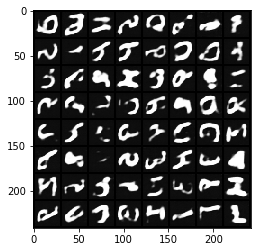

Iteration 401
Iteration 402
Iteration 403
Iteration 404
Iteration 405
Iteration 406
Iteration 407
Iteration 408
Iteration 409
Iteration 410
Iteration 411
Iteration 412
Iteration 413
Iteration 414
Iteration 415
Iteration 416
Iteration 417
Iteration 418
Iteration 419
Iteration 420
Iteration 421
Iteration 422
Iteration 423
Iteration 424
Iteration 425
Iteration 426
Iteration 427
Iteration 428
Iteration 429
Iteration 430
Iteration 431
Iteration 432
Iteration 433
Iteration 434
Iteration 435
Iteration 436
Iteration 437
Iteration 438
Iteration 439
Iteration 440
Iteration 441
Iteration 442
Iteration 443
Iteration 444
Iteration 445
Iteration 446
Iteration 447
Iteration 448
Iteration 449
Iteration 450


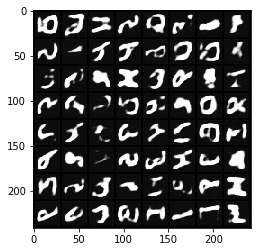

Iteration 451
Iteration 452
Iteration 453
Iteration 454
Iteration 455
Iteration 456
Iteration 457
Iteration 458
Iteration 459
Iteration 460
Iteration 461
Iteration 462
Iteration 463
Iteration 464
Iteration 465
Iteration 466
Iteration 467
Iteration 468
Iteration 469
Iteration 470
Iteration 471
Iteration 472
Iteration 473
Iteration 474
Iteration 475
Iteration 476
Iteration 477
Iteration 478
Iteration 479
Iteration 480
Iteration 481
Iteration 482
Iteration 483
Iteration 484
Iteration 485
Iteration 486
Iteration 487
Iteration 488
Iteration 489
Iteration 490
Iteration 491
Iteration 492
Iteration 493
Iteration 494
Iteration 495
Iteration 496
Iteration 497
Iteration 498
Iteration 499
Iteration 500


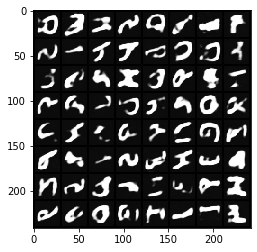

Iteration 501
Iteration 502
Iteration 503
Iteration 504
Iteration 505
Iteration 506
Iteration 507
Iteration 508
Iteration 509
Iteration 510
Iteration 511
Iteration 512
Iteration 513
Iteration 514
Iteration 515
Iteration 516
Iteration 517
Iteration 518
Iteration 519
Iteration 520
Iteration 521
Iteration 522
Iteration 523
Iteration 524
Iteration 525
Iteration 526
Iteration 527
Iteration 528
Iteration 529
Iteration 530
Iteration 531
Iteration 532
Iteration 533
Iteration 534
Iteration 535
Iteration 536
Iteration 537
Iteration 538
Iteration 539
Iteration 540
Iteration 541
Iteration 542
Iteration 543
Iteration 544
Iteration 545
Iteration 546
Iteration 547
Iteration 548
Iteration 549
Iteration 550


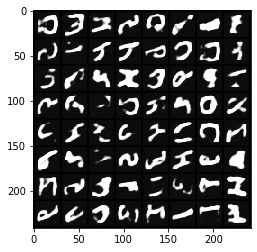

Iteration 551
Iteration 552
Iteration 553
Iteration 554
Iteration 555
Iteration 556
Iteration 557
Iteration 558
Iteration 559
Iteration 560
Iteration 561
Iteration 562
Iteration 563
Iteration 564
Iteration 565
Iteration 566
Iteration 567
Iteration 568
Iteration 569
Iteration 570
Iteration 571
Iteration 572
Iteration 573
Iteration 574
Iteration 575
Iteration 576
Iteration 577
Iteration 578
Iteration 579
Iteration 580
Iteration 581
Iteration 582
Iteration 583
Iteration 584
Iteration 585
Iteration 586
Iteration 587
Iteration 588
Iteration 589
Iteration 590
Iteration 591
Iteration 592
Iteration 593
Iteration 594
Iteration 595
Iteration 596
Iteration 597
Iteration 598
Iteration 599
Iteration 600


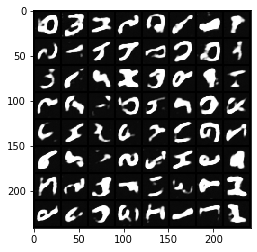

Iteration 601
Iteration 602
Iteration 603
Iteration 604
Iteration 605
Iteration 606
Iteration 607
Iteration 608
Iteration 609
Iteration 610
Iteration 611
Iteration 612
Iteration 613
Iteration 614
Iteration 615
Iteration 616
Iteration 617
Iteration 618
Iteration 619
Iteration 620
Iteration 621
Iteration 622
Iteration 623
Iteration 624
Iteration 625
Iteration 626
Iteration 627
Iteration 628
Iteration 629
Iteration 630
Iteration 631
Iteration 632
Iteration 633
Iteration 634
Iteration 635
Iteration 636
Iteration 637
Iteration 638
Iteration 639
Iteration 640
Iteration 641
Iteration 642
Iteration 643
Iteration 644
Iteration 645
Iteration 646
Iteration 647
Iteration 648


In [ ]:
for epoch in range(1, n_epochs + 1):
    current_epoch_losses = []
    
    for iters, (data, _) in enumerate(train_loader):            
        print('Iteration %d'%iters)
        
        # batch_size x dim_1 x ... x dim_k
        real = data.to(device)
        
        if True:  # if EMNIST!!
            data = data.transpose(2, 3)

        torch.backends.cudnn.benchmark=True  # temporary speed-up
        # batch_size x n_gaussian
        best_z = bcs.optimize(real)
        torch.backends.cudnn.benchmark=False
        
        
        if True:
            best_z = best_z.reshape(batch_size, n_gaussian, 1, 1)
        
        # batch_size x dim_1 x ... x dim_k
        fake = netG(best_z)
        
#         x_train = latent_code_dist.sample(latent_batch_size).to(device)
#         y_train = real.repeat(latent_batch_size, 1)
        
#         y_pred = row_wise_repeat(netG(x_train), batch_size)

#         loss_all_modes = loss_fn(y_pred, y_train)

        # in case we are predicting images with a fully connected net, we have to give it appropriate width and height!
        fake = fake.reshape(real.shape)
        loss = criterion(real, fake)
        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()
#         selective_loss = loss_all_modes.mean(dim=1).reshape(latent_batch_size, batch_size).min(dim=0)[0].sum()
        loss.backward()        
        
        current_epoch_losses.append(loss)
        
        optimizer.step()

        if iters % 50 == 0:           
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
            plt.imshow(img_list[-1].numpy().transpose(1,2,0))
            plt.show()
    
    loss_log.append(torch.tensor(current_epoch_losses).mean().detach().numpy())
    
    if True:  # if epoch % 10 == 0:
        print('Epoch: {} / Loss: {:.2f}'.format(epoch, loss_log[-1]) + '\n' + '=' * 22 + '\n')

In [ ]:
plt.figure()
plt.title('Loss vs Epochs Passed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_log)), loss_log)
plt.show()

In [ ]:
grid_width = 8

x1 = np.linspace(0.02, 0.98, grid_width)
x2 = np.linspace(0.02, 0.98, grid_width)
x1, x2 = norm.ppf(x1), norm.ppf(x2)  # apply inverse normal cdf to distribute codes equally across the distribution

xv1, xv2 = np.meshgrid(x1, x2)
xv1, xv2 = xv1.reshape(-1, 1), xv2.reshape(-1, 1)

y_pred = data.cpu()
y_pred = y_pred.transpose(3,2)

img = torchvision.utils.make_grid(y_pred, nrow=grid_width, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)

plt.imshow(np.transpose(img, (1,2,0)))
plt.axis('off') 

plt.show()

In [ ]:
from scipy.stats import norm
import cv2 as cv

grid_width = 8

if True:
    x_test = torch.randn(grid_width * grid_width, n_gaussian, 1, 1, device=device)
else:
    x_test = torch.randn(grid_width * grid_width, n_gaussian, device=device)

y_pred = netG(x_test).detach().cpu().reshape(-1, 1, img_size, img_size)
y_pred = y_pred.transpose(3,2)

img = torchvision.utils.make_grid(y_pred, nrow=grid_width, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)

plt.figure()
plt.imshow(np.transpose(img, (1,2,0)))
plt.axis('off') 
                            
plt.show()


In [ ]:
from scipy.stats import norm
import cv2 as cv

xv_list = np.meshgrid(*([x1] * n_gaussian))
xv_list = [xv.reshape(-1, 1) for xv in xv_list]

x_test = torch.from_numpy(np.hstack(xv_list)).float().to(device)

y_pred = data.cpu()
y_pred = netG(x_test).detach().cpu().reshape(-1, 1, *img_size)
y_pred = y_pred.transpose(3,2)

nrow = int(np.sqrt(len(y_pred)))
img = torchvision.utils.make_grid(y_pred, nrow=nrow, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(nrow, nrow), dpi=img_size[0])
plt.imshow(np.transpose(img, (1,2,0)))
plt.axis('off') 
                            
# plt.show()
plt.savefig('./fig.png')

# like a fedback network while searching

In [ ]:
!ls '/home/arash/Desktop/celeba/img_align_celeba/' | wc -l